# Introduction to Machine Learning (CS 5710)
# Assignment 2
# Due by 26th September (Thursday) 11:59pm


In this assignment, **you need to complete the following four sectoins**:
1. KNN
2. Linear regression
3. Logistic regression
4. Regularization



## Submission guideline

1. Open this notebook with jupyter notebook and start writing codes
2. After finishing writing your codes, click the Save button at the top of the Jupyter Notebook.
3. Please make sure to have entered your UCM ID below.
4. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells).
5. Select Cell -> Run All. This will run all the cells in order.
6. Once you've rerun everything, select File -> Download as -> HTML or PDF via LaTeX
7. Look at the HTML/PDF file and make sure all your solutions are there, displayed correctly. 
8. Zip BOTH the HTML/PDF file and this .ipynb notebook (updated with your codes). Rem
9. Submit your zipped file.

# Section 1. KNN [30 pts]

The following KNN assignment is modified from [Stanford CS231n](http://cs231n.stanford.edu/). Please complete and hand in this completed worksheet.

In [21]:
# Run some setup code for this notebook.

from __future__ import print_function
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download data:
Once you have the starter code (regardless of which method you choose above), you will need to download the CIFAR-10 dataset. Run the following from the assignment1 directory:

```cd data
./get_datasets.sh
```

In [22]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'data/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


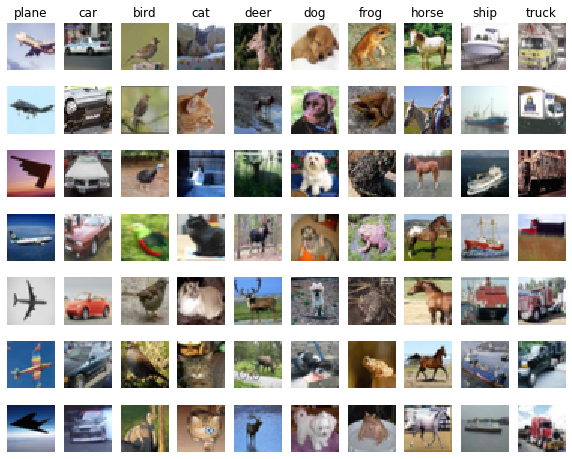

In [23]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [24]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]



In [25]:
X_test.shape

(500, 32, 32, 3)

In [26]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


To make things much structural, we now put everything together into the KNearestNeighbor class. You don't need to implement any fucntion in this class now. Later you will need to come back here and implement the asked function, per the instruction.

In [27]:
import numpy as np
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
  
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the 
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        for j in range(num_train):
        #####################################################################
        # TODO:                                                             #
        # Compute the l2 distance between the ith test point and the jth    #
        # training point, and store the result in dists[i, j]. You should   #
        # not use a loop over dimension.                                    #
        # Use Euclidean distance formula 
        #####################################################################
            dists[i,j]=np.sqrt(np.sum(np.square(X[i,:]-self.X_train[j,:])))

        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      #######################################################################
      # TODO:                                                               #
      # Compute the l2 distance between the ith test point and all training #
      # points, and store the result in dists[i, :].                        #
      #######################################################################
      #######################################################################
        dists[i,:]=np.sqrt(np.sum(np.square(X[i,:]-self.X_train),axis=1))
      #######################################################################
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    #########################################################################
    # TODO:                                                                 #
    # Compute the l2 distance between all test points and all training      #
    # points without using any explicit loops, and store the result in      #
    # dists.                                                                #
    #                                                                       #
    # You should implement this function using only basic array operations; #
    # in particular you should not use functions from scipy.                #
    #                                                                       #
    # HINT: Try to formulate the l2 distance using matrix multiplication    #
    #       and two broadcast sums.                                         #
    #########################################################################
    XSquare=np.square(X).sum(axis=1)
    XtrainSquare=np.square(self.X_train).sum(axis=1)
    XXtrain=np.dot(X,self.X_train.T)
    dists=np.sqrt(np.matrix(XSquare).T+np.matrix(XtrainSquare)-2*XXtrain)

    #########################################################################
    #                         END OF YOUR CODE                              #
    #########################################################################
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0] #num_test has same no of elements as testing data
    y_pred = np.zeros(num_test)
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.
        closest_y=[]

      #########################################################################
      # TODO:                                                                 #
      # Use the distance matrix to find the k nearest neighbors of the ith    #
      # testing point, and use self.y_train to find the labels of these       #
      # neighbors. Store these labels in closest_y.                           #
      # Hint: Look up the function numpy.argsort.                             #
      #########################################################################
        nearestneighbor_index=np.argsort(dists[i,:])[:k]
        closest_y=self.y_train[nearestneighbor_index]
      #########################################################################
      # TODO:                                                                 #
      # Now that you have found the labels of the k nearest neighbors, you    #
      # need to find the most common label in the list closest_y of labels.   #
      # Store this label in y_pred[i]. Break ties by choosing the smaller     #
      # label.                                                                #
      #########################################################################
        y_pred[i]=np.argmax(np.bincount(closest_y))
      #########################################################################
      #                           END OF YOUR CODE                            # 
      #########################################################################

    return y_pred



In [28]:
# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [29]:
# Implement compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


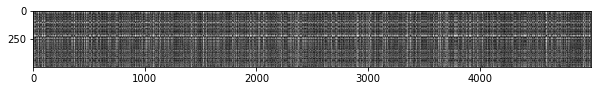

In [30]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

Second, open k_nearest_neighbor.py and implement the function predict_labels that predicts a label for each test point.

In [31]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [32]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


In [33]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [34]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [35]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 75.629673 seconds
One loop version took 109.320406 seconds
No loop version took 0.487917 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [16]:
X_train

array([[ 59.,  62.,  63., ..., 123.,  92.,  72.],
       [154., 177., 187., ..., 143., 133., 144.],
       [255., 255., 255., ...,  80.,  86.,  84.],
       ...,
       [167., 163., 145., ...,  42.,  78.,  84.],
       [154., 152., 125., ..., 194., 247., 114.],
       [ 45.,  32.,  21., ..., 156., 142., 100.]])

In [17]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
#k_choices = [1, 3]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
#we will have 5 subarrays in each X_train_folds and y_train_folds
X_train_folds=np.array_split(X_train,num_folds)
y_train_folds=np.array_split(y_train,num_folds)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.

#creating an empty dictionary
k_to_accuracies={}

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for diffk in k_choices:
    #print('/n diffk=%d'%diffk)
    for foldidx in range(num_folds):
        #print('/n foldidx=%d'%foldidx)
        
        #Test fold 
        X_crossvaltest=X_train_folds[foldidx]
        y_crossvaltest=y_train_folds[foldidx]
        
        #rest of the folds part of training set 
        X_crossvaltrain=np.concatenate(X_train_folds[:foldidx] + X_train_folds[foldidx + 1:])
        y_crossvaltrain=np.concatenate(y_train_folds[:foldidx] + y_train_folds[foldidx + 1:])
        #print(X_crossvaltrain)
        #print(y_crossvaltrain)
        
        #Train the classifier with our training set with modified foldidx
        classifier.train(X_crossvaltrain, y_crossvaltrain)
        
        # Compute the distance between the classifier we trained and our test data created using one of the fold
        dists_crossval_testtrain = classifier.compute_distances_two_loops(X_crossvaltest)
        
        #Predict class labels for the test data 
        y_crossvaltest_pred = classifier.predict_labels(dists_crossval_testtrain, diffk)
        
        #Check how many predictions we made is actually right based on y_crossval test fold samples
        correct_prediction=np.sum(y_crossvaltest_pred==y_crossvaltest)
        
        #Accuracy value on total test samples test samples i.e 500 images
        accuracy_value=float(correct_prediction)/num_test
        
        #keep adding the accuracy values to our dictionary which stores k values and respective 5 values for accuracy 
        #based on which fold we haven for validation set.
        k_to_accuracies[diffk] = k_to_accuracies.get(diffk,[]) + [accuracy_value]
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


k = 1, accuracy = 0.526000
k = 1, accuracy = 0.514000
k = 1, accuracy = 0.528000
k = 1, accuracy = 0.556000
k = 1, accuracy = 0.532000
k = 3, accuracy = 0.478000
k = 3, accuracy = 0.498000
k = 3, accuracy = 0.480000
k = 3, accuracy = 0.532000
k = 3, accuracy = 0.508000
k = 5, accuracy = 0.496000
k = 5, accuracy = 0.532000
k = 5, accuracy = 0.560000
k = 5, accuracy = 0.584000
k = 5, accuracy = 0.560000
k = 8, accuracy = 0.524000
k = 8, accuracy = 0.564000
k = 8, accuracy = 0.546000
k = 8, accuracy = 0.580000
k = 8, accuracy = 0.546000
k = 10, accuracy = 0.530000
k = 10, accuracy = 0.592000
k = 10, accuracy = 0.552000
k = 10, accuracy = 0.568000
k = 10, accuracy = 0.560000
k = 12, accuracy = 0.520000
k = 12, accuracy = 0.590000
k = 12, accuracy = 0.558000
k = 12, accuracy = 0.566000
k = 12, accuracy = 0.560000
k = 15, accuracy = 0.504000
k = 15, accuracy = 0.578000
k = 15, accuracy = 0.556000
k = 15, accuracy = 0.564000
k = 15, accuracy = 0.548000
k = 20, accuracy = 0.540000
k = 20, accu

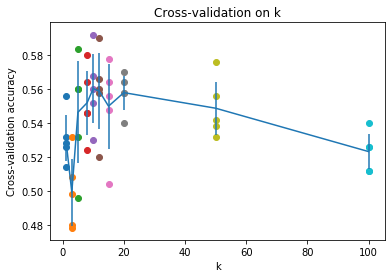

In [18]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [19]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k,num_loops=0)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

ValueError: object too deep for desired array

In [20]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k,num_loops=2)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


In [21]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k,num_loops=1)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


# Section 2. Linear Regression [25 pts]

The following linear regression assignment is modified from [Stanford CS229](http://cs229.stanford.edu//). Please complete and hand in this completed worksheet.

## Linear regression with one variable

Before starting on any task, it is often useful to understand the data by visualizing it. For this dataset, you can use a scatter plot to visualize the data, since it has only two properties to plot (profit and population). (Many other problems that you will encounter in real life are multi-dimensional and can’t be plotted on a 2-d plot.)

The dataset is loaded from the data file into the variables X and y:

In [36]:
data = np.loadtxt('data/ex1data1.txt', delimiter=",") # read comma separated data
m = data.shape[0]                                     # number of training example
X = data[:,0].reshape(m,1)
y = data[:,1].reshape(m,1)                             
print (X.shape)
print (y.shape)

(97, 1)
(97, 1)


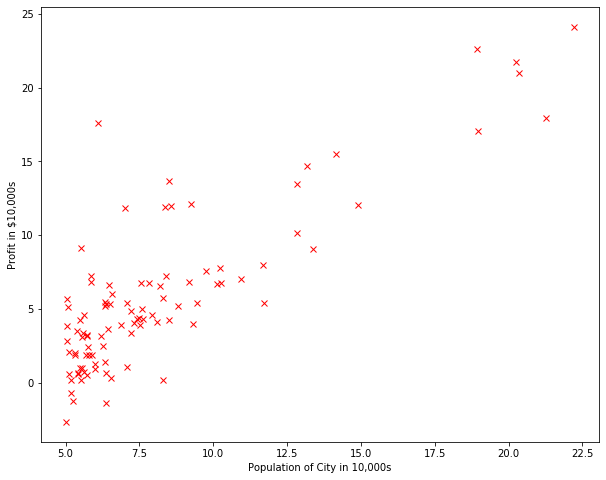

In [38]:
plt.plot(X,y, 'rx')                         # Plot the data
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s')
plt.show()

In this part, you will fit the linear regression parameters $\theta$ to our dataset
using gradient descent.

The objective of linear regression is to minimize the cost function
\begin{equation*}
J(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})^2
\end{equation*}


where the hypothesis $h_\theta(x)$ is given by the linear mode
\begin{equation*}
h_{\theta}(x^{(i)}) = \theta^Tx = \theta_0 + \theta_1 x_1
\end{equation*}


Recall that the parameters of your model are the $\theta_j$ values. These are
the values you will adjust to minimize cost $J(\theta)$. One way to do this is to
use the batch gradient descent algorithm. In batch gradient descent, each
iteration performs the update
\begin{equation*}
\theta_j := \theta_j - \alpha \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)}) x_j^{(i)}
\end{equation*}

With each step of gradient descent, your parameters $\theta_j$ come closer to the
optimal values that will achieve the lowest cost $J(\theta)$.

As you perform gradient descent to learn minimize the cost function J(θ), it is helpful to monitor the convergence by computing the cost. In this section, you will implement a function to calculate J(θ) so you can check the convergence of your gradient descent implementation.

Your next task is to complete the `compute_cost` function, which is a function that computes J(θ). As you are doing this, remember that the variables X and y are not scalar values, but matrices whose rows represent the examples from the training set.

In [39]:
def compute_cost(X, y, theta):
    m = len(y)
    # You need to return the following variables correctly 
    J = 0    #####################################################################
    # Compute the cost of a particular choice of theta                  #
    #               You should set J to the cost.                       #
    #####################################################################
    
    J= np.sum(np.power(np.dot(X, theta) - y, 2))/(2*m)

    #####################################################################
    #                       END OF YOUR CODE                            #
    ####################################################################
    return J

In [40]:
X = np.concatenate((np.ones((m, 1)), data[:,0].reshape(m,1)), axis=1)
theta = np.zeros((2, 1)) 

compute_cost(X, y, theta)

32.072733877455676

You should expect to see a cost of 32.07.

Next, you will implement gradient descent function. The loop structure has been written for you, and you only need to supply the updates to θ within each iteration.

As you program, make sure you understand what you are trying to optimize and what is being updated. Keep in mind that the cost J(θ) is parameterized by the vector θ, not X and y. That is, we minimize the value of J(θ) by changing the values of the vector θ, not by changing X or y.

A good way to verify that gradient descent is working correctly is to look at the value of J(θ) and check that it is decreasing with each step. The starter code calls `compute_cost` on every iteration and prints the cost. Assuming you have implemented gradient descent and `compute_cost` correctly, your value of J(θ) should never increase, and should converge to a steady value by the end of the algorithm.

In [41]:
def gradient_descent(X, y, theta, alpha, num_iters):
    # GRADIENTDESCENT Performs gradient descent to learn theta
    # theta = GRADIENTDESCENT(X, y, theta, alpha, num_iters) updates theta by 
    # taking num_iters gradient steps with learning rate alpha

    # Initialize some useful values
    m = len(y)
    J_history = []

    print(theta)
    for iter in range(num_iters):

        
        #####################################################################
        # Instructions: Perform a single gradient step on the parameter     #
        #               vector theta.                                       #
        #                                                                   #      
        # Hint: While debugging, it can be useful to print out the values   #
        #       of the cost function (compute_cost) and gradient here.       # 
        #####################################################################
   
        temp0 = np.dot(X, theta) - y
        temp1 = np.dot(X.T, temp0)
        theta = theta - (alpha/m) * temp1
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################


        # Save the cost J in every iteration 
        J = compute_cost(X, y, theta)
        print(J)
        print(theta)
        J_history.append(J)
    
    return theta, J_history

Now let's find the parameter θ and plot the linear fit. 

Running Gradient Descent ...

[[0.]
 [0.]]
6.737190464870004
[[0.05839135]
 [0.6532885 ]]
5.9315935686049555
[[0.06289175]
 [0.77000978]]
5.901154707081388
[[0.05782293]
 [0.79134812]]
5.895228586444221
[[0.05106363]
 [0.79572981]]
5.8900949431173295
[[0.04401438]
 [0.79709618]]
5.885004158443647
[[0.03692413]
 [0.79792547]]
5.879932480491418
[[0.02983712]
 [0.79865824]]
5.874879094762575
[[0.02276118]
 [0.79937279]]
5.869843911806385
[[0.0156977 ]
 [0.80008305]]
5.8648268653129305
[[0.0086469]
 [0.8007915]]
5.8598278899321805
[[0.00160879]
 [0.80149857]]
5.85484692057229
[[-0.00541662]
 [ 0.80220436]]
5.849883892376587
[[-0.01242938]
 [ 0.80290886]]
5.844938740722034
[[-0.01942949]
 [ 0.8036121 ]]
5.840011401218361
[[-0.02641699]
 [ 0.80431407]]
5.835101809707226
[[-0.03339189]
 [ 0.80501478]]
5.830209902261388
[[-0.04035421]
 [ 0.80571422]]
5.825335615183862
[[-0.04730399]
 [ 0.8064124 ]]
5.820478885007099
[[-0.05424124]
 [ 0.80710932]]
5.815639648492154
[[-0.06116598]
 [ 0.80780498]

[[-1.36355718]
 [ 0.93864431]]
5.05862772012701
[[-1.36812176]
 [ 0.93910287]]
5.056532627542231
[[-1.37267811]
 [ 0.9395606 ]]
5.0544450813600355
[[-1.37722624]
 [ 0.94001751]]
5.052365054398719
[[-1.38176618]
 [ 0.9404736 ]]
5.050292519574479
[[-1.38629793]
 [ 0.94092886]]
5.0482274499010735
[[-1.39082151]
 [ 0.94138331]]
5.046169818489458
[[-1.39533694]
 [ 0.94183693]]
5.044119598547441
[[-1.39984423]
 [ 0.94228974]]
5.042076763379341
[[-1.4043434 ]
 [ 0.94274172]]
5.040041286385627
[[-1.40883445]
 [ 0.9431929 ]]
5.038013141062576
[[-1.41331741]
 [ 0.94364326]]
5.035992301001939
[[-1.41779229]
 [ 0.94409281]]
5.033978739890578
[[-1.4222591 ]
 [ 0.94454155]]
5.03197243151014
[[-1.42671786]
 [ 0.94498948]]
5.029973349736707
[[-1.43116858]
 [ 0.94543661]]
5.027981468540455
[[-1.43561128]
 [ 0.94588292]]
5.025996761985323
[[-1.44004597]
 [ 0.94632844]]
5.024019204228666
[[-1.44447267]
 [ 0.94677315]]
5.022048769520927
[[-1.44889139]
 [ 0.94721705]]
5.020085432205294
[[-1.45330214]
 [ 0.

 [ 1.04866933]]
4.664293195808771
[[-2.46135057]
 [ 1.04892956]]
4.6636184734239015
[[-2.46393626]
 [ 1.04918932]]
4.662946181350124
[[-2.4665173 ]
 [ 1.04944861]]
4.6622763108336
[[-2.46909369]
 [ 1.04970744]]
4.661608853152018
[[-2.47166543]
 [ 1.0499658 ]]
4.660943799614486
[[-2.47423253]
 [ 1.05022369]]
4.660281141561418
[[-2.47679501]
 [ 1.05048112]]
4.659620870364415
[[-2.47935287]
 [ 1.05073809]]
4.65896297742616
[[-2.48190611]
 [ 1.05099459]]
4.658307454180302
[[-2.48445476]
 [ 1.05125063]]
4.657654292091346
[[-2.48699881]
 [ 1.0515062 ]]
4.657003482654543
[[-2.48953827]
 [ 1.05176132]]
4.6563550173957715
[[-2.49207316]
 [ 1.05201598]]
4.65570888787144
[[-2.49460348]
 [ 1.05227018]]
4.655065085668367
[[-2.49712923]
 [ 1.05252392]]
4.654423602403678
[[-2.49965044]
 [ 1.0527772 ]]
4.653784429724688
[[-2.5021671 ]
 [ 1.05303002]]
4.6531475593088025
[[-2.50467922]
 [ 1.05328239]]
4.652512982863399
[[-2.50718681]
 [ 1.05353431]]
4.651880692125735
[[-2.50968989]
 [ 1.05378577]]
4.651

4.547678616186597
[[-3.01449418]
 [ 1.10449884]]
4.547423932787805
[[-3.01608279]
 [ 1.10465843]]
4.5471701667439195
[[-3.01766853]
 [ 1.10481773]]
4.546917314750677
[[-3.01925141]
 [ 1.10497675]]
4.546665373515724
[[-3.02083144]
 [ 1.10513548]]
4.54641433975856
[[-3.02240862]
 [ 1.10529393]]
4.546164210210502
[[-3.02398295]
 [ 1.10545209]]
4.545914981614642
[[-3.02555445]
 [ 1.10560996]]
4.545666650725801
[[-3.02712312]
 [ 1.10576755]]
4.54541921431049
[[-3.02868896]
 [ 1.10592486]]
4.545172669146869
[[-3.03025198]
 [ 1.10608188]]
4.544927012024698
[[-3.03181217]
 [ 1.10623862]]
4.544682239745306
[[-3.03336956]
 [ 1.10639507]]
4.544438349121538
[[-3.03492414]
 [ 1.10655125]]
4.5441953369777215
[[-3.03647592]
 [ 1.10670714]]
4.543953200149623
[[-3.0380249 ]
 [ 1.10686275]]
4.543711935484407
[[-3.03957108]
 [ 1.10701808]]
4.543471539840591
[[-3.04111448]
 [ 1.10717313]]
4.543232010088012
[[-3.0426551 ]
 [ 1.10732791]]
4.542993343107778
[[-3.04419294]
 [ 1.1074824 ]]
4.542755535792233
[[

4.501270693959463
[[-3.37914768]
 [ 1.14113224]]
4.5011831692183755
[[-3.38007896]
 [ 1.14122579]]
4.501095959736355
[[-3.38100856]
 [ 1.14131918]]
4.501009064377854
[[-3.38193649]
 [ 1.1414124 ]]
4.50092248201142
[[-3.38286274]
 [ 1.14150545]]
4.500836211509674
[[-3.38378732]
 [ 1.14159834]]
4.500750251749297
[[-3.38471024]
 [ 1.14169106]]
4.500664601611016
[[-3.3856315 ]
 [ 1.14178361]]
4.500579259979591
[[-3.38655109]
 [ 1.14187599]]
4.500494225743796
[[-3.38746902]
 [ 1.1419682 ]]
4.500409497796411
[[-3.38838531]
 [ 1.14206026]]
4.500325075034204
[[-3.38929993]
 [ 1.14215214]]
4.500240956357913
[[-3.39021291]
 [ 1.14224386]]
4.500157140672241
[[-3.39112425]
 [ 1.14233541]]
4.500073626885831
[[-3.39203394]
 [ 1.1424268 ]]
4.499990413911261
[[-3.39294199]
 [ 1.14251802]]
4.499907500665023
[[-3.39384841]
 [ 1.14260908]]
4.499824886067514
[[-3.39475319]
 [ 1.14269998]]
4.499742569043016
[[-3.39565634]
 [ 1.14279071]]
4.49966054851969
[[-3.39655786]
 [ 1.14288128]]
4.499578823429556
[[-

[[-3.61451225]
 [ 1.16477716]]
4.484147747565299
[[-3.61501927]
 [ 1.16482809]]
4.484121898688972
[[-3.61552536]
 [ 1.16487894]]
4.4840961429188075
[[-3.61603055]
 [ 1.16492969]]
4.48407047991944
[[-3.61653483]
 [ 1.16498035]]
4.484044909356716
[[-3.6170382 ]
 [ 1.16503092]]
4.484019430897684
[[-3.61754066]
 [ 1.1650814 ]]
4.483994044210589
[[-3.61804221]
 [ 1.16513178]]
4.483968748964877
[[-3.61854286]
 [ 1.16518208]]
4.483943544831179
[[-3.61904261]
 [ 1.16523228]]
4.483918431481318
[[-3.61954146]
 [ 1.1652824 ]]
4.483893408588292
[[-3.62003941]
 [ 1.16533242]]
4.483868475826285
[[-3.62053646]
 [ 1.16538236]]
4.483843632870647
[[-3.62103261]
 [ 1.1654322 ]]
4.483818879397901
[[-3.62152787]
 [ 1.16548195]]
4.4837942150857355
[[-3.62202224]
 [ 1.16553162]]
4.483769639612999
[[-3.62251571]
 [ 1.16558119]]
4.483745152659696
[[-3.6230083 ]
 [ 1.16563068]]
4.483720753906987
[[-3.6235    ]
 [ 1.16568008]]
4.483696443037178
[[-3.62399081]
 [ 1.16572938]]
4.483672219733718
[[-3.62448074]
 [ 1

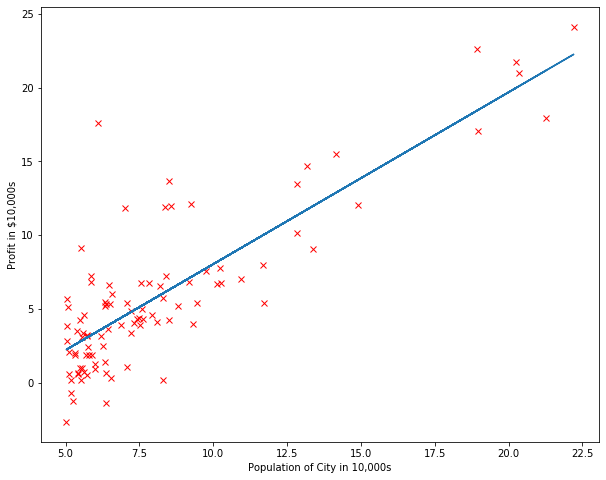

In [42]:
print('Running Gradient Descent ...\n')

X = np.concatenate((np.ones((m, 1)), data[:,0].reshape(m,1)), axis=1) # Add a column of ones to x
theta = np.zeros((2, 1))                                              # initialize fitting parameters

# Some gradient descent settings
iterations = 1500
alpha = 0.01

# gradient descent
theta, J_history = gradient_descent(X, y, theta, alpha, iterations)
print('Theta found by gradient descent: ')
print(theta[0], theta[1])


plt.plot(X[:,1], y, 'rx')                         # Plot the data
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s')

plt.plot(X[:,1], np.dot(X, theta), '-')
plt.show()

## Linear regression with multiple variable

In this part, you will implement linear regression with multiple variables to predict the prices of houses. Suppose you are selling your house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of housing prices.

The file ex1data2.txt contains a training set of housing prices in Portland, Oregon. The first column is the size of the house (in square feet), the second column is the number of bedrooms, and the third column is the price
of the house.

In [43]:
data = np.loadtxt('data/ex1data2.txt', delimiter=",") # read comma separated data
m = data.shape[0]                                     # number of training example
X = data[:,0:2].reshape(m,2)
y = data[:,2].reshape(m,1)   

By looking at the values, note that house sizes are about 1000 times the number of bedrooms. When features differ by orders of magnitude, first performing feature scaling can make gradient descent converge much more quickly.

In [44]:
def feature_normalize(X):
    
    # FEATURENORMALIZE Normalizes the features in X 
    #   FEATURENORMALIZE(X) returns a normalized version of X where the mean value of each
    #   feature is 0 and the standard deviation is 1. This is often a good preprocessing 
    #   step to do when working with learning algorithms.

    # You need to set these values correctly
    X_norm = X
    mu     = 0
    sigma  = 0

    #####################################################################
    # Instructions: First, for each feature dimension, compute the mean #
    #               of the feature and subtract it from the dataset,    #
    #               storing the mean value in mu. Next, compute the     #
    #               standard deviation of each feature and divide       #
    #               each feature by it's standard deviation, storing    #
    #               the standard deviation in sigma.                    #
    #                                                                   #
    #               Note that X is a matrix where each column is a      #
    #               feature and each row is an example. You need        #
    #               to perform the normalization separately for         #
    #               each feature.                                       #
    #                                                                   #
    # Hint: You might find the 'mean' and 'std' functions useful.       #
    #####################################################################
    mu=np.mean(X)
    sigma=np.std(X)
    X_norm=(X-mu)/sigma
    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################


    return X_norm, mu, sigma

Previously, you implemented gradient descent on a univariate regression problem. The only difference now is that there is one more feature in the matrix X. The hypothesis function and the batch gradient descent update
rule remain unchanged.

You should complete the function gradientDescentMulti to implement the gradient descent for linear regression with multiple variables.

Make sure your code supports any number of features and is well-vectorized.

In [45]:
X = np.concatenate((np.ones((m, 1)),feature_normalize(data[:,0:2].reshape(m,2))[0]), axis=1)
theta = np.zeros((3, 1)) 

compute_cost(X, y, theta)

65591548106.45744

You should expect to see a cost of 65591548106.

Next, you will implement gradient descent function with multiple variable.

In [46]:
def gradient_descent_multi(X, y, theta, alpha, num_iters):
    #GRADIENTDESCENTMULTI Performs gradient descent to learn theta
    #   theta = GRADIENTDESCENTMULTI(x, y, theta, alpha, num_iters) updates theta by
    #   taking num_iters gradient steps with learning rate alpha

    # Initialize some useful values
    m = len(y)
    J_history = []
    
    
    for iter in range(num_iters):

        
        #####################################################################
        # Instructions: Perform a single gradient step on the parameter     #
        #               vector theta.                                       #
        #                                                                   #      
        # Hint: While debugging, it can be useful to print out the values   #
        #       of the cost function (compute_cost) and gradient here.      # 
        #####################################################################
        temp0 = np.dot(X, theta) - y
        temp1 = np.dot(X.T, temp0)
        theta = theta - (alpha/m) * temp1
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################


        # Save the cost J in every iteration 
        J = compute_cost(X, y, theta)
        print(J)
        J_history.append(J)
    
    return theta, J_history

Now let's find the parameter θ and plot the linear fit.

In [47]:
alpha = 0.01;
num_iters = 400;
print(np.dot(X,theta).shape)
theta = np.zeros((3, 1))
theta, J_history = gradient_descent_multi(X, y, theta, alpha, num_iters)


(47, 1)
62223785532.307274
59034726299.371056
56014886726.82392
53155286434.36299
50447421631.92049
47883239826.8984
45455115873.6974
43155829294.30339
40978542802.47641
38916781967.66677
36964415958.17245
35115639306.2622
33364954641.02842
31707156337.612064
30137315034.16765
28650762970.516808
27243080104.88359
25910080967.418114
24647802211.40733
23452490825.14622
22320592969.408127
21248743407.313545
20233755495.158443
19272611704.432068
18362454646.833702
17500578575.594177
16684421337.824442
15911556753.95519
15179687401.601519
14486637782.389877
13830347851.42327
13208866890.139389
12620347704.337868
12063041130.119637
11535290831.397612
11035528373.504751
10562268558.24711
10114105006.526781
9689705975.396198
9287810397.102472
8907224128.340652
8546816398.560095
8205516446.7601385
7882310336.77188
7576237941.553794
7286390087.531546
7011905850.488417
6751969994.963538
6505810549.541902
6272696510.82434
6051935669.248437
5842872550.293638
5644886464.9471445
5457389663.632088
527

Let's plot the convergence graph

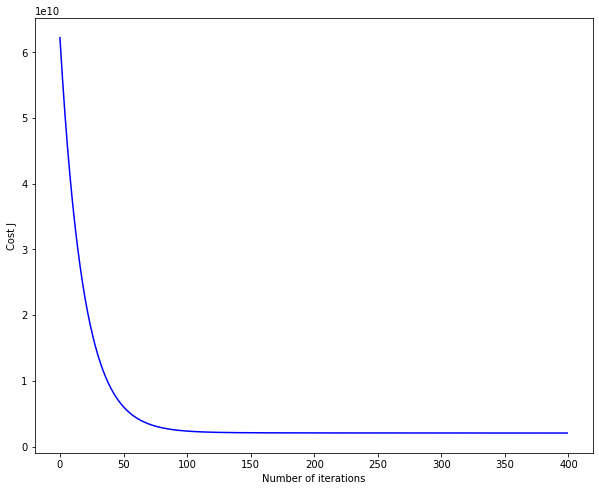

In [48]:
plt.plot(list(range(0, len(J_history))), J_history, '-b')                         # Plot the data
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')
plt.show()

# Section 3. Logistic Regression [25 pts]

The following logistic regression assignment is modified from [Stanford CS229](http://cs229.stanford.edu//). Please complete and hand in this completed worksheet.

## Logistic Regression
In this section, you need to implement logsitic regression to solve a binary classification problem. Let's first get our data ready:

In [5]:
# Only use the first 70 samples for training (and validation),
# and treat the rest of them as hold-out testing set.
X = np.loadtxt('data/logistic_x_.txt') 
y = np.loadtxt('data/logistic_y_.txt').reshape(-1, 1) 


X, mu, std = feature_normalize(X)

# Add a column of ones to X for the bias weight.
m = len(X)
X = np.concatenate((np.ones((m, 1)), X), axis=1)

Here, the input $x^{(i)}\in\mathbb{R^2}$ and $y^{(i)}\in\{-1, 1\}$. Like we have mentioned, it is better to visualize the data first before you start working on it.

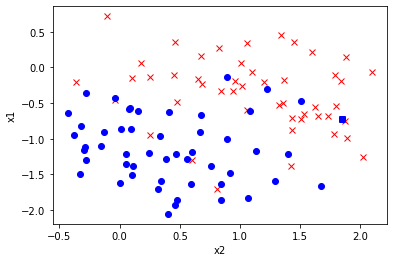

In [6]:
# Plot the feature according to their class label.
# Note that we exclude column 0, which is the colunm we padded with one in the previous block.
plt.plot(X[np.where(y==1), 1], X[np.where(y==1), 2], 'rx')
plt.plot(X[np.where(y==-1), 1], X[np.where(y==-1), 2], 'bo')  
plt.xlabel('x2')
plt.ylabel('x1')
plt.show()

In the following, you need to implement logistic regression. Recall that when $y^{(i)}\in{-1,1}$, the objective function for binary logistic regression can be expressed as:
\begin{equation*}
J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\log{\left(1+e^{-y^{(i)\theta^Tx^{(i)}}}\right)}=-\frac{1}{m}\sum_{i=1}^m\log{\left(h_{\theta}(y^{(i)}x^{(i)})\right)}
\end{equation*}
where the hypothesis is the **sigmoid function**: 
\begin{equation*}
h_\theta(y^{(i)}x^{(i)})=\frac{1}{1+e^{-y^{(i)}\theta^{T}x^{(i)}}}
\end{equation*}
which we have seen in class (and assignment 0). Similar to the previous section, we can minimize the objective function $J(\theta)$ using  batch gradient descent:
\begin{equation*}
\theta_j := \theta_j - \alpha \frac{1}{m}\sum_{i=1}^{m}h_\theta(-y^{(i)}x_j^{(i)})(-y^{(i)}x_j^{(i)})
\end{equation*}

Now, your task is to complete the function `sigmoid`, `compute_cost`, `gradient_descent` for logistic regression.

In [7]:
def sigmoid(z):
    #####################################################################
    # Instructions: Implement sigmoid function g                        #
    #####################################################################
    g=1/(1+np.exp(-z))
    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
    return g

def compute_cost(X, y, theta):
    
    # You need to return the following variables correctly 
    J = 0;
    #####################################################################
    # Instructions: Implement the objective function J(theta)           #
    #####################################################################
    z1 = np.dot(X, theta)
    z2 = y*z1
    #z2=np.dot(y.T,z1)
    h = sigmoid(z2)
    cost=np.sum(np.log(h))
    J=cost*(-1/m)
    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
    return J

def compute_gradient(X, y, theta):
    #####################################################################
    # Instructions: Implement gradient function gradient_               #
    #####################################################################
    z1 = np.dot(X, theta)
    z2=-y*z1
    #z2=np.dot(-y,z1.T)
    h=sigmoid(z2)
    #z3=h*(-y*X)
    #z3=np.dot((-y*X).T,h)
    z3=np.dot(h.T,(-y*X))
    z4=np.sum(z3)
    gradient_=z4/m
    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
    return gradient_


def gradient_descent_logistic(X, y, theta, alpha, num_iters):
    m = len(y)
    J_history = []
    for iter in range(num_iters):
        #theta = 0

        #####################################################################
        # Instructions: Perform a single gradient step on the parameter     #
        #               vector theta using the implemented compute_gradient #
        #                                                                   #      
        # Hint: While debugging, it can be useful to print out the values   #
        #       of the cost function (compute_cost) and gradient here.      # 
        #####################################################################
        #print('\nIteration %d' %iter)
        grad=compute_gradient(X, y, theta)
        #print('grad')
        #print(grad)
        theta=theta-(alpha*grad)
        #print('theta')
        #print(theta)
        
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################


        # Save the cost J in every iteration 
        J = compute_cost(X, y, theta)
        print(J)
        J_history.append(J)
    
    return theta, J_history

Now, fit your model, and see if it is learning.

In [8]:
# Train your model.
theta = np.zeros((X.shape[1], 1))
alpha = 0.1;
num_iters = 400;
theta, J_history = gradient_descent_logistic(X, y, theta, alpha, num_iters)

0.679901134031402
0.667954823162029
0.6571765034242333
0.6474456258703198
0.638652779585832
0.6306992986514286
0.6234966493366055
0.6169656890088558
0.611035865403712
0.6056444052341909
0.6007355252202315
0.5962596863863926
0.5921729034526881
0.5884361147454411
0.585014613702474
0.5818775402274614
0.5789974284403627
0.5763498064441785
0.5739128433333359
0.5716670386227859
0.5695949494486228
0.5676809511895204
0.5659110275215584
0.5642725863061157
0.5627542980954395
0.5613459544074797
0.5600383432619086
0.5588231397788126
0.5576928099192698
0.5566405256936418
0.5556600903807634
0.554745872491697
0.5538927473779351
0.5530960455285435
0.55235150672626
0.5516552393413384
0.5510036841361122
0.5503935820347347
0.549821945383052
0.5492860322845446
0.5487833236510591
0.548311502652735
0.5478684362911337
0.5474521588538965
0.5470608570390535
0.5466928565629867
0.5463466100885559
0.5460206863294903
0.5457137602042295
0.5454246039272996
0.5451520789393342
0.5448951285882366
0.5446527714839696
0.5

Again, plot and check to see if the model is converging.

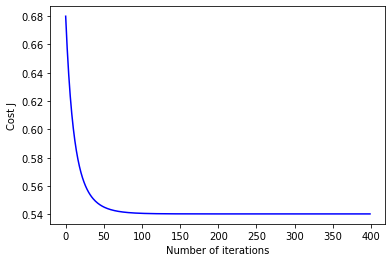

[[0.95764717]
 [0.95764717]
 [0.95764717]]


In [9]:
plt.plot(list(range(0, len(J_history))), J_history, '-b')  
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')
plt.show()
print (theta)

## Decision Boundary
In addition to checking convergence graph and accuracy, we can also plot out the decision boundary to see what does the model actually learn.

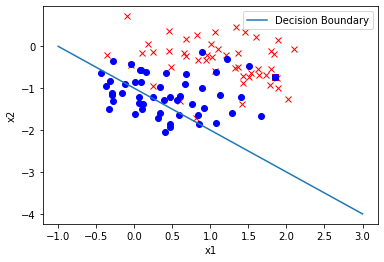

In [10]:
# Plot the feature according to their class label.
# Note that we exclude column 0, which is the colunm we padded with one in the previous block.
plt.plot(X[np.where(y==1), 1], X[np.where(y==1), 2], 'rx')
plt.plot(X[np.where(y==-1), 1], X[np.where(y==-1), 2], 'bo')

#####################################################################
# Instructions: Plot out the decision boundary.                     #
# Hint: To plot the boundary, which is a straight line in our case, #
#       you need to find the two ends of the line, and plot it with #
#       plt.plot(). Note that the decision boundary is the line that#
#       y = 0.                                                      # 
#####################################################################
# getting the x co-ordinates of the decision boundary
plot_x = np.array([min(X[:,0]) - 2, max(X[:,0]) + 2])
# getting corresponding y co-ordinates of the decision boundary
plot_y = (-1/theta[2]) * (theta[1] * plot_x + theta[0])
plt.plot(plot_x, plot_y, label = "Decision Boundary")
plt.legend()
#####################################################################
#                       END OF YOUR CODE                            #
#####################################################################

plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Section 4. Regularization [30 pts]

In this section, you need to incorporate L2 regularization into your logistic regression. 

## L2 Regularization
Overfitting is a notorious problem in the world of machine learning. One simple way to counter this issue is to put constraints on your model weights $\theta$, as we have discussed in class. In this section, you need to modify the the objective function to impose L2 regularization on the logistic regression:
\begin{equation*}
    J(\theta) = -\frac{1}{m}\sum_{i=1}^m\log{\left(h_{\theta}(y^{(i)}x^{(i)})\right)} + \lambda\vert\vert\theta\vert\vert_2^2
\end{equation*}
Derive the gradient for this new objective to incorporate it into your logistic regression model.

To make things much structural, we now put everything together into a class. Please use the class template below to implement your logistic regression. Note that you can add your own class methods if needed.

In [11]:
class LogisticRegression(object):
    
    def __init__(self, alpha=0.1, lamb=0.1, regularization=None):
        # setting the class attribute.
        self.alpha = alpha                   # Set up your learning rate alpha.
        self.lamb = lamb                     # Strength of regularization.
        self.regularization = regularization 
        assert regularization == 'l2' or regularization == None # we only consider these two cases
    
    def sigmoid(self,z):
        g=1/(1+np.exp(-z))
        return g
    
    def _compute_cost(self, X, y):
        #####################################################################
        # Instructions: Compute the cost function here.                     #
        #               You need to handle both the cases with, and without #
        #               regularization here.                                #
        #####################################################################
        J = 0;
        m = X.shape[0]
        z1 = np.dot(X, self.theta)
        z2 = y*z1
        h = self.sigmoid(z2)
        cost=np.sum(np.log(h))
        J=cost*(-1/m)
        
        #With regularization
        reg=self.lamb*(self.theta**2)
        if(self.regularization=='l2'):
            #print('\nComputing cost with regularization')
            #print('\nreg=%f',%reg)
            J=J+reg
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
        return J
        
    def _compute_gradient(self, X, y):
        #####################################################################
        # Instructions: Compute the gradient here.                          #
        #               You need to handle both the cases with, and without #
        #               regularization here.                                #
        #####################################################################
        #####################################################################
        m = X.shape[0]
        z1 = np.dot(X, self.theta)
        z2=-y*z1
        h=self.sigmoid(z2)
        z3=h*(-y*X)
        z4=np.sum(z3)
        gradient=z4/m
        
        #With regularization
        if(self.regularization=='l2'):
            #print('Computing gradient with regularization')
            #reg=(self.lamb/m) * self.theta
            reg=2*(self.lamb) * self.theta
            gradient=gradient+reg
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
        return gradient

    def fit(self, X, y, num_iter=5):
        self.theta = np.zeros((X.shape[1], 1))
        m = len(y)
        J_history = []
        #####################################################################
        for i in range(num_iter):
            cost =self._compute_cost(X,y)
            #print('cost is %f' %cost)
            grad =self._compute_gradient(X, y)
            #print(grad)
            self.theta = self.theta - (self.alpha * grad)
            #print(self.theta)
            J_history.append(cost)
        #####################################################################
       
        #                       END OF YOUR CODE                            #
        #####################################################################
        return J_history
    
    def predict(self, X):
        #####################################################################
        # Instructions: Use your hypothese to make predictions.             #
        #####################################################################
        num_examples, num_features = np.shape(X)
        y_hat = []
        for sample in range(num_examples):
            yhat = 0
            for value in range(num_features):
                yhat += X[sample, value] * self.theta[value]  
            pred = self.sigmoid(yhat)
            y_hat.append(pred)
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
        return y_hat

Load the wine datasets, in which $x_j\in\mathbb{R}^{12}$ is different attribute for alcohol, and $y\in\{-1,1\}$ is that class label (red or white wine).

In [12]:
# Load dataset
X_train = np.loadtxt('data/wine_train_X.txt')
y_train = np.loadtxt('data/wine_train_y.txt').reshape(-1, 1)
X_test = np.loadtxt('data/wine_test_X.txt')
y_test = np.loadtxt('data/wine_test_y.txt').reshape(-1, 1)

X_train, mu, std = feature_normalize(X_train)
X_test, mu, std = feature_normalize(X_test)


X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
X_test = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)


Now, let's train two different logistic regression models: one with, and one without regularization.

In [13]:
log_reg = LogisticRegression(alpha=0.1) # Without regularization
log_reg_l2 = LogisticRegression(alpha=0.1, lamb=1.0, regularization='l2') # Without regularization

J_history = log_reg.fit(X_train, y_train, num_iter=500)
J_history_l2 = log_reg_l2.fit(X_train, y_train, num_iter=500)


In [14]:
J_history

[0.6931471805599452,
 0.6201589627230633,
 0.568726736422999,
 0.5315762454394015,
 0.5039066746857591,
 0.482686978869771,
 0.46599284654021134,
 0.45257202334329505,
 0.44158474610931564,
 0.43245084611944407,
 0.42475832205485936,
 0.41820727834598265,
 0.4125745801836216,
 0.407690950835127,
 0.40342574376943974,
 0.39967657434474857,
 0.39636210552477424,
 0.39341692821980223,
 0.3907878624163801,
 0.3884312409088011,
 0.38631088477726777,
 0.38439657385623877,
 0.3826628767419893,
 0.3810882455736272,
 0.37965430828930713,
 0.3783453099008235,
 0.3771476674466286,
 0.3760496125413479,
 0.3750409020585064,
 0.37411258227176697,
 0.3732567952834178,
 0.3724666191589431,
 0.37173593512022407,
 0.37105931660691527,
 0.37043193612288167,
 0.3698494866330625,
 0.36930811493126336,
 0.36880436490892415,
 0.3683351290539374,
 0.367897606823117,
 0.36748926878136673,
 0.3671078255995953,
 0.36675120116306437,
 0.36641750917059795,
 0.36610503270943734,
 0.3658122063755128,
 0.365537600578

In [15]:
J_history_l2

[array([[0.69314718],
        [0.69314718],
        [0.69314718],
        [0.69314718],
        [0.69314718],
        [0.69314718],
        [0.69314718],
        [0.69314718],
        [0.69314718],
        [0.69314718],
        [0.69314718],
        [0.69314718],
        [0.69314718]]), array([[0.62810723],
        [0.62810723],
        [0.62810723],
        [0.62810723],
        [0.62810723],
        [0.62810723],
        [0.62810723],
        [0.62810723],
        [0.62810723],
        [0.62810723],
        [0.62810723],
        [0.62810723],
        [0.62810723]]), array([[0.60155152],
        [0.60155152],
        [0.60155152],
        [0.60155152],
        [0.60155152],
        [0.60155152],
        [0.60155152],
        [0.60155152],
        [0.60155152],
        [0.60155152],
        [0.60155152],
        [0.60155152],
        [0.60155152]]), array([[0.59043166],
        [0.59043166],
        [0.59043166],
        [0.59043166],
        [0.59043166],
        [0.59043166],
       

In [17]:
def evaluate_accuracy(X, y, model):
    y_pred = model.predict(X)
    for i in range(len(y_pred)):
        if y_pred[i]>0.5:
            y_pred[i]=1
        if y_pred[i]<=0.5:
            y_pred[i]=-1
    return np.mean(y_pred == y)

In [18]:
print("Accuracy on training set: ", evaluate_accuracy(X_train, y_train, log_reg))
print("Accuracy on testing set: ", evaluate_accuracy(X_test, y_test, log_reg))
print("Accuracy w/ L2 training set: ", evaluate_accuracy(X_train, y_train, log_reg_l2))
print("Accuracy w/ L2 testing set: ", evaluate_accuracy(X_test, y_test, log_reg_l2))

Accuracy on training set:  0.499771875
Accuracy on testing set:  0.5
Accuracy w/ L2 training set:  0.499771875
Accuracy w/ L2 testing set:  0.5


Next, we evaluate the accuracy for each method:

In [39]:
def evaluate_accuracy(X, y, model):
    y_pred = model.predict(X)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = -1
    return np.mean(y_pred == y)

print("Accuracy on training set: ", evaluate_accuracy(X_train, y_train, log_reg))
print("Accuracy on testing set: ", evaluate_accuracy(X_test, y_test, log_reg))
print("Accuracy w/ L2 training set: ", evaluate_accuracy(X_train, y_train, log_reg_l2))
print("Accuracy w/ L2 testing set: ", evaluate_accuracy(X_test, y_test, log_reg_l2))

Accuracy on training set:  0.9925
Accuracy on testing set:  0.9925
Accuracy w/ L2 training set:  0.9925
Accuracy w/ L2 testing set:  0.9925


To see the effect of regularization on $\theta$, we can plot out each $\theta_j$ under different $\lambda$.

In [19]:
def plot_theta(theta, lamb):
    """
    Helper function for plotting out the value of theta with respect to different lambda.
    theta  (list): list of theta under different lambda.
    lambda (list): list of lambda values you tried.
    """
    plt.hlines(y=0, xmin=0, xmax=np.max(lamb), color='red', linewidth = 2, linestyle = '--')
    for i in range(theta.shape[1]):
        plt.plot(lamb, theta[:,i])
    plt.ylabel('theta')
    plt.xlabel('lambda')
    plt.xscale('log')
    plt.show()

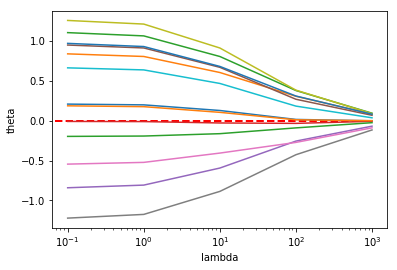

In [41]:
lamb = [0.1, 1, 10, 100, 1000]
theta = []

#####################################################################
# Instructions: For each value in lamb, try a model for it, and     #
#               append the trained weights into the theta           #
#####################################################################
all_J=[]
for i,val in enumerate(lamb):
    log_reg_l2_model = LogisticRegression(alpha=0.1, lamb=val, regularization='l2')
    J_history_model=log_reg_l2_model.fit(X_train, y_train, num_iter=500)
    #theta=log_reg_l2_model.theta
    #lamb=val
    theta.extend(log_reg_l2_model.theta)
    all_J.extend(J_history_model)
#####################################################################
#                       END OF YOUR CODE                            #
#####################################################################

plot_theta(np.array(theta), lamb)